In [91]:
import pandas as pd
import numpy as np
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.utils import resample

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

 Функция для обработки текста. Нижний регистр => удаление стоп-слов => Портера стеммер => удаляем токены короче 2 символов. В конце склеиваем обратно в строку, чтобы не проделывать обработку каждый раз, когда строим матрицу признаков.

In [34]:
stemmer = SnowballStemmer("russian")
stop_words = stopwords.words("russian")
def preprocess(text):
    min_length = 3
    words = [word.lower() for word in word_tokenize(text) if word.lower() not in stop_words]
    stems = [stemmer.stem(token) for token in words]
    tokens = [token for token in stems if len(token)>=min_length]
    return " ".join(tokens)


In [3]:
df = pd.read_csv("lenta_data.csv")
df.head()

,tags,text,title,topic,url
0,Деловой климат,Заместитель председателя правительства Аркадий...,Правительство прокомментировало идею о запрете...,Бизнес,https://lenta.ru/news/2017/04/01/24hours/
1,События,Монреальская конвенция об унификации правил во...,Эксперт отвел год на окончательную ратификацию...,Путешествия,https://lenta.ru/news/2017/03/31/motrealwork/
2,Общество,Сотни байкеров в столице Аргентины Буэнос-Айре...,Аргентинские байкеры устроили акцию протеста п...,Мир,https://lenta.ru/news/2017/03/30/bikers/
3,Политика,Прямая линия с президентом России Владимиром П...,Прямая линия с Путиным пройдет позже обычного,Россия,https://lenta.ru/news/2017/03/30/straightahead/
4,Футбол,Нападающий английского «Сандерленда» Данкан Уо...,Английский футболист спас трех человек на отды...,Спорт,https://lenta.ru/news/2017/03/30/duncanwatmore/


In [4]:
df['text'].map(lambda x: len(x.split())).describe()

count    635617.000000
mean        181.105496
std          71.437225
min           1.000000
25%         133.000000
50%         172.000000
75%         219.000000
max        9016.000000
Name: text, dtype: float64

#### Тексты в среднем 180 слов.

In [5]:
df['title'].map(lambda x: len(x.split())).describe()

count    635617.000000
mean          7.451184
std           1.751855
min           1.000000
25%           6.000000
50%           7.000000
75%           9.000000
max          18.000000
Name: title, dtype: float64

In [6]:
topic_counts = df['topic'].value_counts()
topic_counts

Россия               147863
Мир                  124749
Финансы               72736
Спорт                 55395
Культура              48264
Наука и техника       48129
Бывший СССР           47722
Интернет и СМИ        38729
Из жизни              23267
Силовые структуры     13959
Бизнес                 6026
Путешествия            4006
Ценности               3816
69-я параллель          567
Крым                    116
Легпром                 114
Культпросвет             85
Библиотека               65
Недвижимость              3
Оружие                    2
ЧМ-2014                   2
Сочи                      1
МедНовости                1
Name: topic, dtype: int64

#### Удаляем слабопредставленные темы.

In [7]:
rare_topics = topic_counts[topic_counts < 1000].keys()
rare_topics

Index(['69-я параллель', 'Крым', 'Легпром', 'Культпросвет ', 'Библиотека',
       'Недвижимость', 'Оружие', 'ЧМ-2014', 'Сочи', 'МедНовости'],
      dtype='object')

In [8]:
df.drop(df[df['topic'].isin(rare_topics)].index, inplace=True)

In [9]:
df['topic'].value_counts()

Россия               147863
Мир                  124749
Финансы               72736
Спорт                 55395
Культура              48264
Наука и техника       48129
Бывший СССР           47722
Интернет и СМИ        38729
Из жизни              23267
Силовые структуры     13959
Бизнес                 6026
Путешествия            4006
Ценности               3816
Name: topic, dtype: int64

In [15]:
%%time
df['title_processed'] = df['title'].map(preprocess)

Wall time: 11min 36s


In [13]:
%%time
df['text_processed'] = df['text'].map(preprocess)

Wall time: 4h 11min 55s


In [14]:
df.to_csv("preprocessed_news.csv", sep='\t', encoding='utf-8', index=False, columns=['tags', 'text_processed', 'title_processed', 'topic'])

In [2]:
df = pd.read_csv("preprocessed_news.csv", sep='\t', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634661 entries, 0 to 634660
Data columns (total 4 columns):
tags               634661 non-null object
text_processed     634658 non-null object
title_processed    634661 non-null object
topic              634661 non-null object
dtypes: object(4)
memory usage: 19.4+ MB


In [3]:
df.head()

,tags,text_processed,title_processed,topic
0,Деловой климат,заместител председател правительств аркад двор...,правительств прокомментирова запрет круглосуто...,Бизнес
1,События,монреальск конвенц унификац прав воздушн перев...,эксперт отвел год окончательн ратификац монреа...,Путешествия
2,Общество,сотн байкер столиц аргентин буэнос-айрес приня...,аргентинск байкер устро акц протест прот шлем ...,Мир
3,Политика,прям лин президент росс владимир путин 2017 го...,прям лин путин пройдет позж обычн,Россия
4,Футбол,напада английск сандерленд данка уотмор спас т...,английск футболист спас трех человек отдых бар...,Спорт


#### Есть null значения, но мало, удалим их.

In [3]:
df.drop(df[df['text_processed'].isnull()].index, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634658 entries, 0 to 634660
Data columns (total 4 columns):
tags               634658 non-null object
text_processed     634658 non-null object
title_processed    634658 non-null object
topic              634658 non-null object
dtypes: object(4)
memory usage: 24.2+ MB



### Обучаемся на текстах новостей.

#### Разбиваем выборку на обучающую и тестовую, стандартные параметры: перемешивание и разбиение 3 к 1.

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text_processed'], df['topic'], random_state=17)

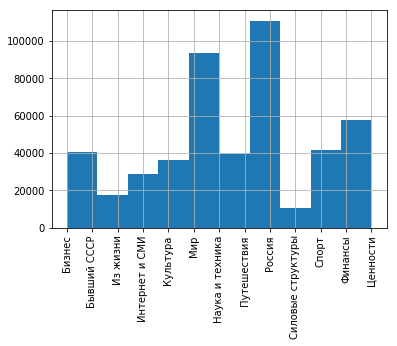

In [104]:
plt.xticks(rotation='vertical')
train_y.hist()

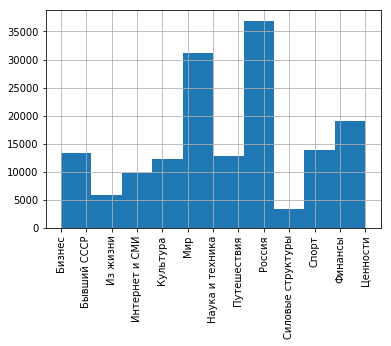

In [106]:
plt.xticks(rotation='vertical')
valid_y.hist()

#### Т.е. разбиение пропорционально классам.

In [5]:
train_x.head()

8411      первомайск суд мурманск оправда капита траулер...
249213    административн комисс фсин направ суд материал...
479898    руководител управлен госохра украин валер геле...
610394    физик австр канад австрал наблюда пар одиночн ...
590781    напада барселон лионел месс приня участ японск...
Name: text_processed, dtype: object

In [7]:
encoder = preprocessing.LabelEncoder()
train_y_labels = encoder.fit_transform(train_y)
valid_y_labels = encoder.fit_transform(valid_y)

## Наивный байесовский классификатор

In [83]:
pipeline_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2)),
    ('clf', naive_bayes.MultinomialNB())
])

Попробуем подобрать следующие параметры:
* число признаков *k* в отборе 
* сглаживание *alpha* в классификаторе

In [84]:
k = [2000, 10000, 50000, 100000]
scores = ['f1_macro', 'f1_micro']
param_grid = [
    {
        'dim_red__k': k,
    }
]

In [85]:
nb_grid = model_selection.GridSearchCV(estimator=pipeline_nb, cv = 3, 
                                       param_grid=param_grid, n_jobs=2, scoring=scores, refit='f1_micro', verbose=10)

In [86]:
%%time
nb_grid_res = nb_grid.fit(train_x, train_y_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 10.2min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 23.7min
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed: 28.9min finished


Wall time: 30min 21s


In [87]:
nb_grid_res.cv_results_

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_f1_micro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are ac

{'mean_fit_time': array([ 80.84286785,  87.56164638,  83.18368228,  73.02465034]),
 'mean_score_time': array([ 63.27508171,  61.82872979,  58.10117237,  61.71723557]),
 'mean_test_f1_macro': array([ 0.60844064,  0.68045806,  0.61845062,  0.56290315]),
 'mean_test_f1_micro': array([ 0.74337438,  0.78786453,  0.788291  ,  0.77350717]),
 'mean_train_f1_macro': array([ 0.61112217,  0.69095031,  0.63836222,  0.58355266]),
 'mean_train_f1_micro': array([ 0.74381557,  0.79178896,  0.79683735,  0.78508823]),
 'param_dim_red__k': masked_array(data = [2000 10000 50000 100000],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'dim_red__k': 2000},
  {'dim_red__k': 10000},
  {'dim_red__k': 50000},
  {'dim_red__k': 100000}],
 'rank_test_f1_macro': array([3, 1, 2, 4]),
 'rank_test_f1_micro': array([4, 2, 1, 3]),
 'split0_test_f1_macro': array([ 0.60823544,  0.68011867,  0.61993326,  0.56218258]),
 'split0_test_f1_micro': array([ 0.74246225,  0.7865165 ,  0.7871845

#### Смотрим на средние значения оценок на тестовых сплитах, из данных значений лучшим является при *k = 10 000*.

In [88]:
pipeline_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2, k=10000)),
    ('clf', naive_bayes.MultinomialNB())
])

In [91]:
alpha = [1e-2, 1e-1, 1]
scores = ['f1_macro', 'f1_micro']
param_grid = [
    {
        'clf__alpha': alpha,
    }
]

In [92]:
nb_grid = model_selection.GridSearchCV(estimator=pipeline_nb, cv = 3, param_grid=param_grid,
                                       n_jobs=2, scoring=scores, refit='f1_micro', verbose=10, return_train_score=True)

In [93]:
%%time
nb_grid_res = nb_grid.fit(train_x, train_y_labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done   7 out of   9 | elapsed: 18.7min remaining:  5.3min
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 22.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 22.3min finished


Wall time: 23min 57s


In [94]:
nb_grid_res.cv_results_

{'mean_fit_time': array([ 78.60774763,  90.85415943,  72.94453788]),
 'mean_score_time': array([ 59.75944161,  60.54053609,  56.49108624]),
 'mean_test_f1_macro': array([ 0.7187947 ,  0.71560987,  0.68045806]),
 'mean_test_f1_micro': array([ 0.79500959,  0.79416714,  0.78786453]),
 'mean_train_f1_macro': array([ 0.73578444,  0.72982295,  0.69095031]),
 'mean_train_f1_micro': array([ 0.80174079,  0.79977542,  0.79178896]),
 'param_clf__alpha': masked_array(data = [0.01 0.1 1],
              mask = [False False False],
        fill_value = ?),
 'params': [{'clf__alpha': 0.01}, {'clf__alpha': 0.1}, {'clf__alpha': 1}],
 'rank_test_f1_macro': array([1, 2, 3]),
 'rank_test_f1_micro': array([1, 2, 3]),
 'split0_test_f1_macro': array([ 0.71804834,  0.71518377,  0.68011867]),
 'split0_test_f1_micro': array([ 0.79385257,  0.79298283,  0.7865165 ]),
 'split0_train_f1_macro': array([ 0.73706573,  0.73079621,  0.69115921]),
 'split0_train_f1_micro': array([ 0.80250217,  0.80052627,  0.79244308]),
 

*alpha = 0.01*

In [271]:
pipeline_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2, k=10000)),
    ('clf', naive_bayes.MultinomialNB(alpha=1e-2))
])

In [273]:
nb_unbalanced = pipeline_nb.fit(train_x, train_y_labels)

In [274]:
%%time
nb_prediction_unbalanced = nb_unbalanced.predict(valid_x)

Wall time: 23.4 s


In [296]:
metrics.f1_score(valid_y_labels, nb_prediction_unbalanced, average='macro'), \
metrics.f1_score(valid_y_labels, nb_prediction_unbalanced, average='micro'), \
metrics.f1_score(valid_y_labels, nb_prediction_unbalanced, average='weighted')

(0.7224784145319606, 0.7956638199981092, 0.79129132428041637)

In [276]:
print(metrics.classification_report(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, target_names=encoder.classes_))

                   precision    recall  f1-score   support

           Бизнес       0.62      0.28      0.39      1465
      Бывший СССР       0.78      0.74      0.76     11917
         Из жизни       0.64      0.50      0.56      5909
   Интернет и СМИ       0.77      0.65      0.70      9773
         Культура       0.85      0.89      0.87     12244
              Мир       0.78      0.82      0.80     31219
  Наука и техника       0.82      0.81      0.82     11851
      Путешествия       0.69      0.61      0.65      1000
           Россия       0.75      0.81      0.78     36942
Силовые структуры       0.53      0.31      0.39      3400
            Спорт       0.97      0.95      0.96     13854
          Финансы       0.83      0.87      0.85     18136
         Ценности       0.85      0.87      0.86       955

      avg / total       0.79      0.80      0.79    158665



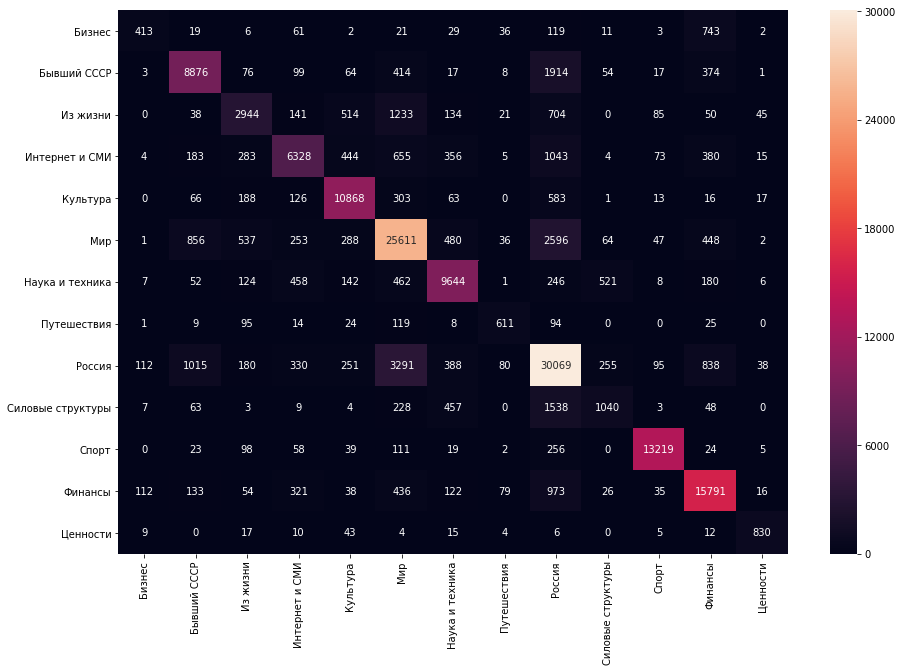

In [277]:
cm = metrics.confusion_matrix(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels)
plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='.5g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

 Можно заметить, что страдают некоторые малопредставленные классы: *Бизнес*, *Из жизни*, *Силовые структуры* имеют низкое значение полноты, т.е. часто ложно относятся к классам, которые сильнее представлены в коллекции.

## Машина опорных векторов

C линейным ядром

In [58]:
pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2)),
    ('clf', svm.LinearSVC(C = 1))
])

#### Аналогично, подберем размер словаря с использованием кросс-валидации.

In [61]:
k = [2000, 10000, 50000, 100000]
scores = ['f1_micro', 'f1_macro']
param_grid = [
    {
        'dim_red__k': k,
    }
]

In [62]:
svm_grid = model_selection.GridSearchCV(estimator=pipeline_svm, cv = 3, 
                                        param_grid=param_grid, n_jobs=2, scoring=scores, refit='f1_micro')

In [63]:
%%time
svm_grid_res = svm_grid.fit(train_x, train_y_labels)

Wall time: 38min 58s


In [74]:
svm_grid_res.cv_results_

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_f1_micro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are ac

{'mean_fit_time': array([ 138.15480344,  143.84265749,  149.96434824,  121.8545924 ]),
 'mean_score_time': array([ 58.96638028,  58.74128723,  73.15260108,  58.80556575]),
 'mean_test_f1_macro': array([ 0.74697215,  0.80293963,  0.81626335,  0.81710256]),
 'mean_test_f1_micro': array([ 0.81270523,  0.8451868 ,  0.85348524,  0.85486551]),
 'mean_train_f1_macro': array([ 0.76019369,  0.85027988,  0.91905207,  0.9391753 ]),
 'mean_train_f1_micro': array([ 0.81929882,  0.87089097,  0.91762379,  0.93541607]),
 'param_dim_red__k': masked_array(data = [2000 10000 50000 100000],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'dim_red__k': 2000},
  {'dim_red__k': 10000},
  {'dim_red__k': 50000},
  {'dim_red__k': 100000}],
 'rank_test_f1_macro': array([4, 3, 2, 1]),
 'rank_test_f1_micro': array([4, 3, 2, 1]),
 'split0_test_f1_macro': array([ 0.7450598 ,  0.80150033,  0.81552489,  0.8158046 ]),
 'split0_test_f1_micro': array([ 0.81050369,  0.84325762,  0.852

#### Переход от *k = 50 000* к *k = 100 000* не дает существенного улучшения оценки, поэтому остановимся на *k = 50 000*.

In [135]:
pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2, k=50000)),
    ('clf', svm.LinearSVC())
])

In [136]:
C = [0.01, 0.1, 1, 10]
scores = ['f1_micro', 'f1_macro']
param_grid = [
    {
        'clf__C': C,
    }
]

In [137]:
svm_grid = model_selection.GridSearchCV(estimator=pipeline_svm, cv = 3, 
                                        param_grid=param_grid, n_jobs=2, scoring=scores, refit='f1_micro')

In [138]:
%%time
svm_grid_res = svm_grid.fit(train_x, train_y_labels)

Wall time: 44min 6s


In [139]:
svm_grid_res.cv_results_

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_f1_micro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are ac

{'mean_fit_time': array([ 194.58471282,  150.62817105,  140.80820282,  268.93825372]),
 'mean_score_time': array([ 59.50206772,  62.98153178,  58.47793754,  61.28575333]),
 'mean_test_f1_macro': array([ 0.69012949,  0.78875834,  0.81626223,  0.79934313]),
 'mean_test_f1_micro': array([ 0.81388802,  0.84723305,  0.85348314,  0.83831275]),
 'mean_train_f1_macro': array([ 0.70077024,  0.82995719,  0.91905189,  0.96647465]),
 'mean_train_f1_micro': array([ 0.82017804,  0.87132374,  0.91762379,  0.95329869]),
 'param_clf__C': masked_array(data = [0.01 0.1 1 10],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'clf__C': 0.01}, {'clf__C': 0.1}, {'clf__C': 1}, {'clf__C': 10}],
 'rank_test_f1_macro': array([4, 3, 1, 2]),
 'rank_test_f1_micro': array([4, 2, 1, 3]),
 'split0_test_f1_macro': array([ 0.68789574,  0.78695618,  0.81552489,  0.79822664]),
 'split0_test_f1_micro': array([ 0.81158772,  0.84529332,  0.85218822,  0.8370686 ]),
 'split0_train_f1_macro'

In [286]:
pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2, k=50000)),
    ('clf', svm.LinearSVC(C=1))
])

In [287]:
svm_unbalanced = pipeline_svm.fit(train_x, train_y_labels)

In [288]:
%%time
svm_prediction_unbalanced = svm_unbalanced.predict(valid_x)

Wall time: 23 s


In [295]:
metrics.f1_score(valid_y_labels, svm_prediction_unbalanced, average='macro'), \
metrics.f1_score(valid_y_labels, svm_prediction_unbalanced, average='micro'), \
metrics.f1_score(valid_y_labels, svm_prediction_unbalanced, average='weighted')

(0.82307656408834184, 0.85858254813600987, 0.85693926909289664)

In [291]:
print(metrics.classification_report(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, target_names=encoder.classes_))

                   precision    recall  f1-score   support

           Бизнес       0.75      0.53      0.62      1465
      Бывший СССР       0.86      0.89      0.87     11917
         Из жизни       0.73      0.62      0.67      5909
   Интернет и СМИ       0.82      0.77      0.79      9773
         Культура       0.90      0.92      0.91     12244
              Мир       0.83      0.86      0.85     31219
  Наука и техника       0.87      0.88      0.87     11851
      Путешествия       0.86      0.76      0.81      1000
           Россия       0.84      0.86      0.85     36942
Силовые структуры       0.79      0.58      0.67      3400
            Спорт       0.97      0.98      0.97     13854
          Финансы       0.89      0.90      0.89     18136
         Ценности       0.94      0.90      0.92       955

      avg / total       0.86      0.86      0.86    158665



In [292]:
cm = metrics.confusion_matrix(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels)

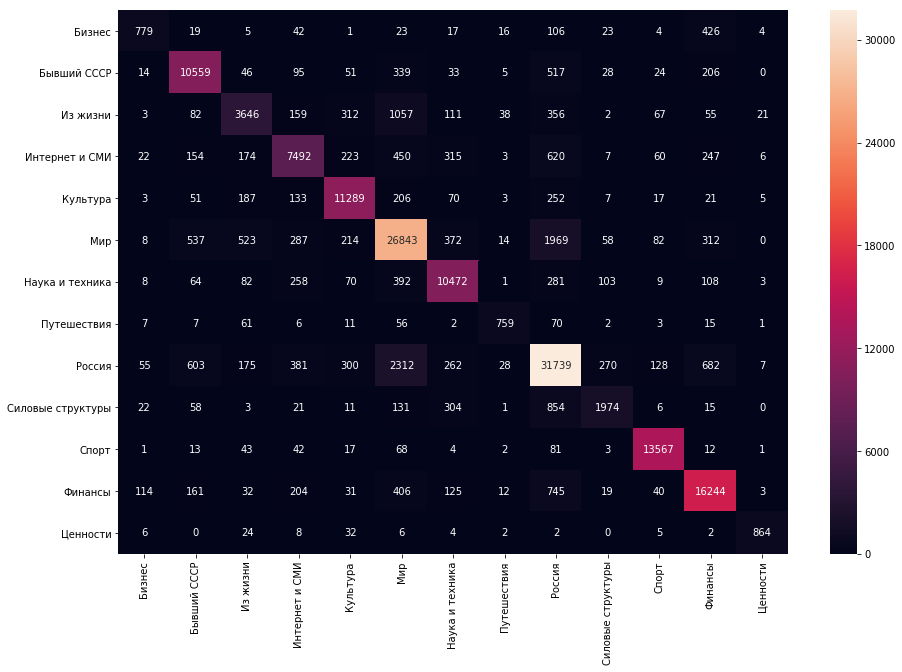

In [293]:
plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='.5g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

Получившаяся SVM модель гораздо лучше подошла для работы с данной несбалансированной коллекцией, в сравнении с байесовским классификатором. Каждый класс имеет большую и точность, и полноту.

Ниже представлены таблицы сравнения оценок для двух методов: по классам и усредненные.

In [294]:
metrics1 = metrics.precision_recall_fscore_support(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average=None)
metrics2 = metrics.precision_recall_fscore_support(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average=None)

resdf = pd.DataFrame(np.array(metrics1).transpose(), columns=['precision','recall','f1','support'])
resdf['method'] = 'SVM'
resdf2 = pd.DataFrame(np.array(metrics2).transpose(), columns=['precision','recall','f1','support'])
resdf2['method'] = 'NB'

ddf = pd.concat([resdf, resdf2], axis=0)
ddf.index = ddf.index.map(dict(zip(resdf.index, encoder.classes_)).get)
ddf['support'] =ddf['support'].astype(int)
ddf = ddf.reset_index() \
    .rename(columns ={'index': 'topic'}) \
    .set_index(['topic', 'support', 'method']) \
    .sort_index() \
    .round(2)
    
ddf

precision  recall    f1
topic             support method                         
Бизнес            1465    NB           0.62    0.28  0.39
                          SVM          0.75    0.53  0.62
Бывший СССР       11917   NB           0.78    0.74  0.76
                          SVM          0.86    0.89  0.87
Из жизни          5909    NB           0.64    0.50  0.56
                          SVM          0.73    0.62  0.67
Интернет и СМИ    9773    NB           0.77    0.65  0.70
                          SVM          0.82    0.77  0.79
Культура          12244   NB           0.85    0.89  0.87
                          SVM          0.90    0.92  0.91
Мир               31219   NB           0.78    0.82  0.80
                          SVM          0.83    0.86  0.85
Наука и техника   11851   NB           0.82    0.81  0.82
                          SVM          0.87    0.88  0.87
Путешествия       1000    NB           0.69    0.61  0.65
                          SVM          0.86    0.76  0.81
Россия            36942   NB           0.75    0.81  0.78
                          SVM          0.84    0.86  0.85
Силовые структуры 3400    NB           0.53    0.31  0.39
                          SVM          0.79    0.58  0.67
Спорт             13854   NB           0.97    0.95  0.96
                          SVM          0.97    0.98  0.97
Финансы           18136   NB           0.83    0.87  0.85
                          SVM          0.89    0.90  0.89
Ценности          955     NB           0.85    0.87  0.86
                          SVM          0.94    0.90  0.92

In [308]:
metrics3 = np.array([
    [
        'NB',
        metrics.precision_score(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average='micro'),
        metrics.precision_score(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average='macro'),
        metrics.recall_score(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average='micro'),
        metrics.recall_score(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average='macro'),
        metrics.f1_score(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average='micro'),
        metrics.f1_score(y_pred=nb_prediction_unbalanced, y_true=valid_y_labels, average='macro'),
    ],
    [
        'SVM',
        metrics.precision_score(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average='micro'),
        metrics.precision_score(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average='macro'),
        metrics.recall_score(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average='micro'),
        metrics.recall_score(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average='macro'),
        metrics.f1_score(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average='micro'),
        metrics.f1_score(y_pred=svm_prediction_unbalanced, y_true=valid_y_labels, average='macro'),
    ]
])
columns = ['method', 'prec-micro', 'prec-macro', 'rec-micro', 'rec-macro', 'F1-micro', 'F1-macro']
pd.DataFrame(metrics3, columns=columns).set_index('method').astype(float).round(2)

,prec-micro,prec-macro,rec-micro,rec-macro,F1-micro,F1-macro
method,,,,,,
NB,0.80,0.76,0.80,0.7,0.80,0.72
SVM,0.86,0.85,0.86,0.8,0.86,0.82


Вывод: опираясь на выбранные метрики качества, из данных моделей предпочтение отдаем модели SVM.

# UPD



Утверждалось, что SVM работает лучше NB поскольку классы в задаче несбалансированные. Если привести принудительную балансировку классов, сохранится ли этот вывод?

Ожидается, что да. SVM часто в задаче классификации текстов показывает результаты лучше, чем NB. Исключения обычно - небольшие коллекции коротких текстов.

Но можно смоделировать балансировку и проверить.



Данная функция определяет стратегию разбиения для кросс-валидации.
* class_size : желаемое число объектов каждого класса
* class_labels : список уникальных меток классов
* n_splits : число фолдов для разбиения

В начале разбиваем X, y на обуч.\тест. подвыборки, далее ресемплируем в обучащей выборке каждый класс, до желаемого количества объектов.

In [268]:
class UpsampleStratifiedKFold:
    def __init__(self, class_size, class_labels, n_splits=3):
        self.n_splits = n_splits
        self.class_size = class_size
        self.class_labels = class_labels

    def split(self, X, y):
        for train, test in model_selection.StratifiedKFold(n_splits=self.n_splits).split(X,y):
            idx = np.array([], dtype=int)
            for label in self.class_labels:
                train_labels = np.where(y[train]==label)[0]
                need_replace = True if train_labels.size < self.class_size else False
                sample = np.random.choice(train_labels, self.class_size, replace=need_replace)
                idx = np.append(idx, sample)
            resampled_train = np.random.permutation(train[idx])
            yield resampled_train, test

    def get_n_splits(self, X, y):
        return self.n_splits

Как и ранее, посмотрим на влияние параметров на оценки качества. Количество признаков оставим тем же для обоих методов.

In [9]:
pipeline_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2, k=10000)),
    ('clf', naive_bayes.MultinomialNB(alpha=1e-2))
])

In [15]:
unique_classes, counts = np.unique(train_y_labels, return_counts=True)
counts

array([  4561,  35805,  17358,  28955,  36020,  93529,  36277,   3006,
       110921,  10559,  41541,  54600,   2861], dtype=int64)

Ниже два черновых запуска кросс-валидации для оценки времени ее работы в зависимости от выбранного размера класса (13 классов вызывали опасения, что выборка очень быстро растет).

In [62]:
%%time
stratifier = UpsampleStratifiedKFold(50000, unique_classes, 3)
scoring = ['f1_macro', 'recall_macro', 'precision_macro']
cvres = model_selection.cross_validate(pipeline_nb, train_x, train_y_labels, cv=stratifier,
                                       scoring=scoring, n_jobs=2, verbose=10, return_train_score=True)

[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 17.6min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 17.6min finished


Wall time: 17min 38s


In [63]:
cvres

{'fit_time': array([ 148.4681983 ,  138.48241329,   99.52821541]),
 'score_time': array([ 82.38274288,  81.40164518,  64.97961473]),
 'test_f1_macro': array([ 0.6958857 ,  0.69561662,  0.69739523]),
 'test_precision_macro': array([ 0.66609024,  0.66597424,  0.66738168]),
 'test_recall_macro': array([ 0.77895874,  0.7769163 ,  0.7776849 ]),
 'train_f1_macro': array([ 0.80548852,  0.80321791,  0.80449246]),
 'train_precision_macro': array([ 0.80857294,  0.8066123 ,  0.80785543]),
 'train_recall_macro': array([ 0.80466154,  0.80231692,  0.80343692])}

In [57]:
%%time
stratifier = UpsampleStratifiedKFold(90000, unique_classes, 3)
scoring = ['f1_macro', 'recall_macro', 'precision_macro']
cvres2 = model_selection.cross_validate(pipeline_nb, train_x, train_y_labels, cv=stratifier,
                                        scoring=scoring, n_jobs=2, verbose=10, return_train_score=True)

[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 31.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 31.2min finished


Wall time: 31min 13s


In [58]:
cvres2

{'fit_time': array([ 273.69279265,  259.98858738,  187.19719052]),
 'score_time': array([ 84.35333681,  84.26976323,  67.08048606]),
 'test_f1_macro': array([ 0.69544756,  0.69527993,  0.69805879]),
 'test_precision_macro': array([ 0.66612009,  0.66571898,  0.66746882]),
 'test_recall_macro': array([ 0.7774021 ,  0.77667772,  0.77818641]),
 'train_f1_macro': array([ 0.80472031,  0.80305691,  0.80356471]),
 'train_precision_macro': array([ 0.80794618,  0.80629896,  0.8066604 ]),
 'train_recall_macro': array([ 0.8038735 ,  0.80215641,  0.80261111])}

Оставим размер класса 50 000. Подберем параметр сглаживания для наивного байеса.

In [67]:
alpha = [1e-2, 1e-1, 1]
scores = ['f1_macro', 'f1_micro']
param_grid = [
    {
        'clf__alpha': alpha,
    }
]
stratifier = UpsampleStratifiedKFold(50000, unique_classes, 3)

In [68]:
nb_grid = model_selection.GridSearchCV(estimator=pipeline_nb, cv = stratifier, param_grid=param_grid,
                                       n_jobs=2, scoring=scores, refit='f1_macro', verbose=10, return_train_score=True)

In [122]:
%%time
nb_grid_res = nb_grid.fit(train_x, train_y_labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 15.7min
[Parallel(n_jobs=2)]: Done   7 out of   9 | elapsed: 29.5min remaining:  8.4min
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 35.0min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed: 35.0min finished


Wall time: 36min 35s


In [142]:
nb_grid.cv_results_

{'mean_fit_time': array([ 146.2735277 ,  146.54253324,  129.85334953]),
 'mean_score_time': array([ 54.61569357,  54.92283487,  49.32605664]),
 'mean_test_f1_macro': array([ 0.69608674,  0.69370378,  0.69017465]),
 'mean_test_f1_micro': array([ 0.76316879,  0.761507  ,  0.75858469]),
 'mean_train_f1_macro': array([ 0.80380555,  0.8009464 ,  0.79634013]),
 'mean_train_f1_micro': array([ 0.80291744,  0.80008205,  0.79550821]),
 'param_clf__alpha': masked_array(data = [0.01 0.1 1],
              mask = [False False False],
        fill_value = ?),
 'params': [{'clf__alpha': 0.01}, {'clf__alpha': 0.1}, {'clf__alpha': 1}],
 'rank_test_f1_macro': array([1, 2, 3]),
 'rank_test_f1_micro': array([1, 2, 3]),
 'split0_test_f1_macro': array([ 0.69527083,  0.69253662,  0.68892212]),
 'split0_test_f1_micro': array([ 0.76187385,  0.7599579 ,  0.75712179]),
 'split0_train_f1_macro': array([ 0.80466182,  0.80182597,  0.79738199]),
 'split0_train_f1_micro': array([ 0.80391385,  0.80109846,  0.79669231])

Разницы практически нет, оставим alpha = 0.01 как и для несбалансированного случая, и посмотрим на оценку на тестовой подвыборке. Для этого нужно вначале ресемплировать обучающую подвыборку, по той же стратегии, что использовалась выше.

In [85]:
train_df, valid_df = model_selection.train_test_split(df, random_state=17)
train_df.head()

,tags,text_processed,title_processed,topic
8411,Все,первомайск суд мурманск оправда капита траулер...,суд оправда капита траулер электрон,Россия
249213,Следствие и суд,административн комисс фсин направ суд материал...,фсин направ суд материал васильев,Силовые структуры
479898,Все,руководител управлен госохра украин валер геле...,руководител управлен госохра украин открест ин...,Бывший СССР
610394,Наука,физик австр канад австрал наблюда пар одиночн ...,физик запута фотон наибольш квантов числ,Наука и техника
590781,Футбол,напада барселон лионел месс приня участ японск...,месс обыгра гигантск вратаря-робот,Спорт


In [89]:
train_df.drop(['tags', 'title_processed'], axis=1, inplace=True)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
def group_resample(group, size):
    need_replace = True if group.shape[0] < size else False
    return resample(group, replace=need_replace, n_samples=size, random_state=123)

In [137]:
train_balanced = train_df.groupby('topic').apply(lambda x: group_resample(x, 50000)) \
                            .reset_index(drop=True).sample(frac=1, random_state=123)

In [138]:
train_balanced.head()

,text_processed,topic
165732,сам известн радиоведущ сша говард стерн увол ф...,Интернет и СМИ
505897,канадск фигурист патрик чан котор явля одн гла...,Спорт
130111,херсонск област украин задержа дво местн жител...,Из жизни
382591,туристическ сервис рамблер.путешеств запуст пр...,Путешествия
562940,совокупн обь списан проч убытк понесен финансо...,Финансы


In [139]:
train_x_balanced = train_balanced['text_processed']
train_y_balanced = train_balanced['topic']

In [140]:
train_y_balanced_labels = encoder.transform(train_y_balanced)

Обучаем на полученной выборке NB.

In [146]:
nb_balanced = pipeline_nb.fit(train_x_balanced, train_y_balanced_labels)

In [147]:
nb_prediction = nb_balanced.predict(valid_x)

In [153]:
metrics.f1_score(valid_y_labels, nb_prediction, average='macro'), \
metrics.f1_score(valid_y_labels, nb_prediction, average='micro'), \
metrics.f1_score(valid_y_labels, nb_prediction, average='weighted'),

(0.6952108070393479, 0.76152900765764342, 0.77308903759768999)

In [152]:
print(metrics.classification_report(y_pred=nb_prediction, y_true=valid_y_labels, target_names=encoder.classes_))

                   precision    recall  f1-score   support

           Бизнес       0.24      0.74      0.36      1465
      Бывший СССР       0.71      0.83      0.76     11917
         Из жизни       0.44      0.76      0.55      5909
   Интернет и СМИ       0.69      0.71      0.70      9773
         Культура       0.86      0.88      0.87     12244
              Мир       0.83      0.72      0.77     31219
  Наука и техника       0.84      0.75      0.79     11851
      Путешествия       0.31      0.83      0.46      1000
           Россия       0.84      0.69      0.76     36942
Силовые структуры       0.35      0.62      0.44      3400
            Спорт       0.97      0.95      0.96     13854
          Финансы       0.86      0.77      0.81     18136
         Ценности       0.69      0.92      0.79       955

      avg / total       0.80      0.76      0.77    158665



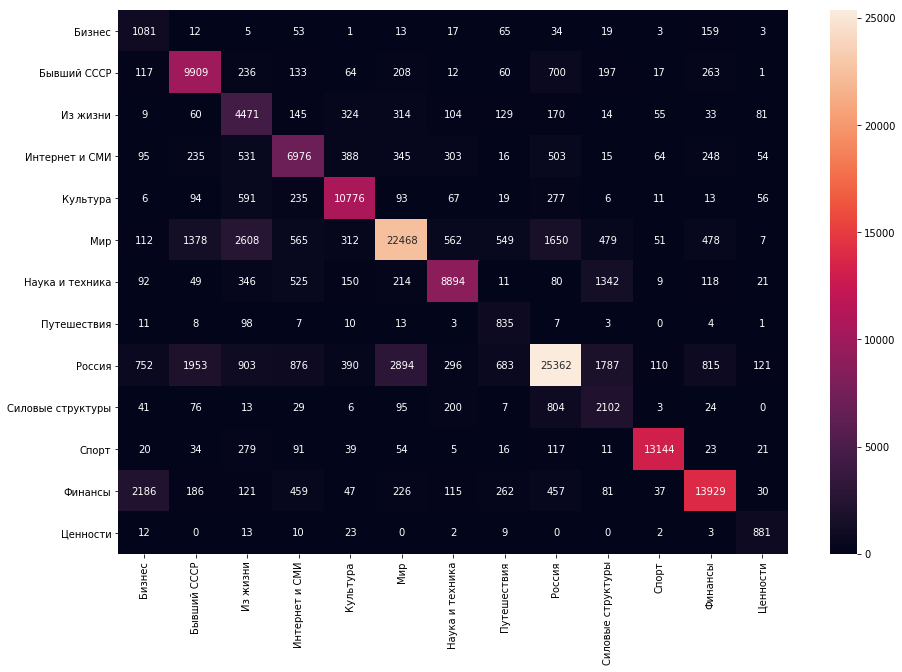

In [154]:
cm = metrics.confusion_matrix(y_pred=nb_prediction, y_true=valid_y_labels)
plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='.5g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

Аналогичный порядок действий для SVC.

In [70]:
pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_red', SelectKBest(chi2, k=50000)),
    ('clf', svm.LinearSVC(C=1))
])

In [71]:
C = [0.01, 0.1, 1, 10]
scores = ['f1_micro', 'f1_macro']
param_grid = [
    {
        'clf__C': C,
    }
]

In [72]:
svm_grid = model_selection.GridSearchCV(estimator=pipeline_svm, cv = stratifier, param_grid=param_grid,
                                        n_jobs=2, scoring=scores, refit='f1_macro', return_train_score=True)

In [73]:
%%time
svm_grid_res = svm_grid.fit(train_x, train_y_labels)

Wall time: 1h 21min 5s


In [83]:
svm_grid_res.cv_results_

{'mean_fit_time': array([ 462.68030167,  280.32467675,  281.83186372,  710.53798103]),
 'mean_score_time': array([ 52.28894075,  55.7300547 ,  75.80369703,  51.76951925]),
 'mean_test_f1_macro': array([ 0.74313846,  0.79279332,  0.8036271 ,  0.78207276]),
 'mean_test_f1_micro': array([ 0.79878906,  0.83012355,  0.83489043,  0.81883347]),
 'mean_train_f1_macro': array([ 0.87252042,  0.92783851,  0.96452181,  0.98437043]),
 'mean_train_f1_micro': array([ 0.87399282,  0.92872256,  0.96499385,  0.98452513]),
 'param_clf__C': masked_array(data = [0.01 0.1 1 10],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'clf__C': 0.01}, {'clf__C': 0.1}, {'clf__C': 1}, {'clf__C': 10}],
 'rank_test_f1_macro': array([4, 2, 1, 3]),
 'rank_test_f1_micro': array([4, 2, 1, 3]),
 'split0_test_f1_macro': array([ 0.74275089,  0.7907507 ,  0.8029669 ,  0.78165723]),
 'split0_test_f1_micro': array([ 0.79777901,  0.82798674,  0.83352661,  0.81789649]),
 'split0_train_f1_macro'

С = 1

In [155]:
svm_balanced = pipeline_svm.fit(train_x_balanced, train_y_balanced_labels)

In [156]:
svm_prediction = svm_balanced.predict(valid_x)

In [157]:
metrics.f1_score(valid_y_labels, svm_prediction, average='macro'), \
metrics.f1_score(valid_y_labels, svm_prediction, average='micro'), \
metrics.f1_score(valid_y_labels, svm_prediction, average='weighted')

(0.80692726674296955, 0.83635332303910759, 0.83830500841415501)

In [158]:
print(metrics.classification_report(y_pred=svm_prediction, y_true=valid_y_labels, target_names=encoder.classes_))

                   precision    recall  f1-score   support

           Бизнес       0.55      0.76      0.64      1465
      Бывший СССР       0.81      0.91      0.86     11917
         Из жизни       0.57      0.74      0.65      5909
   Интернет и СМИ       0.76      0.81      0.78      9773
         Культура       0.89      0.92      0.90     12244
              Мир       0.85      0.80      0.83     31219
  Наука и техника       0.84      0.87      0.86     11851
      Путешествия       0.69      0.85      0.76      1000
           Россия       0.89      0.75      0.82     36942
Силовые структуры       0.53      0.81      0.64      3400
            Спорт       0.97      0.97      0.97     13854
          Финансы       0.87      0.89      0.88     18136
         Ценности       0.90      0.91      0.91       955

      avg / total       0.85      0.84      0.84    158665



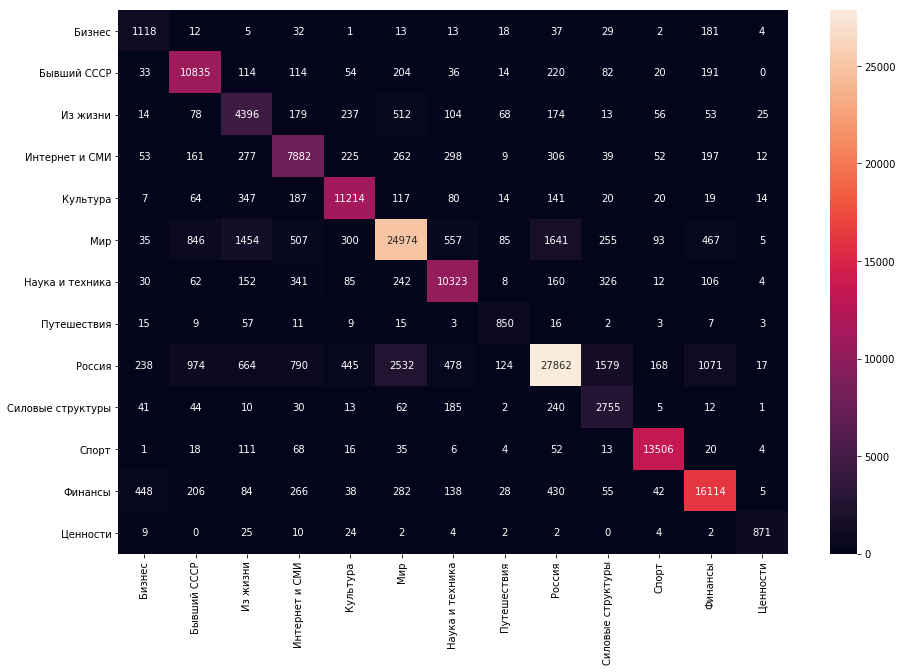

In [159]:
cm = metrics.confusion_matrix(y_pred=svm_prediction, y_true=valid_y_labels)
plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='.5g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

In [269]:
metrics1 = metrics.precision_recall_fscore_support(y_pred=svm_prediction, y_true=valid_y_labels, average=None)
metrics2 = metrics.precision_recall_fscore_support(y_pred=nb_prediction, y_true=valid_y_labels, average=None)

resdf = pd.DataFrame(np.array(metrics1).transpose(), columns=['precision','recall','f1','support'])
resdf['method'] = 'SVM'
resdf2 = pd.DataFrame(np.array(metrics2).transpose(), columns=['precision','recall','f1','support'])
resdf2['method'] = 'NB'

ddf = pd.concat([resdf, resdf2], axis=0)
ddf.index = ddf.index.map(dict(zip(resdf.index, encoder.classes_)).get)
ddf['support'] =ddf['support'].astype(int)
ddf = ddf.reset_index() \
    .rename(columns ={'index': 'topic'}) \
    .set_index(['topic', 'support', 'method']) \
    .sort_index() \
    .round(2)
    
ddf

precision  recall    f1
topic             support method                         
Бизнес            1465    NB           0.24    0.74  0.36
                          SVM          0.55    0.76  0.64
Бывший СССР       11917   NB           0.71    0.83  0.76
                          SVM          0.81    0.91  0.86
Из жизни          5909    NB           0.44    0.76  0.55
                          SVM          0.57    0.74  0.65
Интернет и СМИ    9773    NB           0.69    0.71  0.70
                          SVM          0.76    0.81  0.78
Культура          12244   NB           0.86    0.88  0.87
                          SVM          0.89    0.92  0.90
Мир               31219   NB           0.83    0.72  0.77
                          SVM          0.85    0.80  0.83
Наука и техника   11851   NB           0.84    0.75  0.79
                          SVM          0.84    0.87  0.86
Путешествия       1000    NB           0.31    0.84  0.46
                          SVM          0.69    0.85  0.76
Россия            36942   NB           0.84    0.69  0.76
                          SVM          0.89    0.75  0.82
Силовые структуры 3400    NB           0.35    0.62  0.44
                          SVM          0.53    0.81  0.64
Спорт             13854   NB           0.97    0.95  0.96
                          SVM          0.97    0.97  0.97
Финансы           18136   NB           0.86    0.77  0.81
                          SVM          0.87    0.89  0.88
Ценности          955     NB           0.69    0.92  0.79
                          SVM          0.90    0.91  0.91

Снова лучше себя показывает SVM. По каждому классу его точно как минимум не уступает показателю NB, а в большинстве случаев значительно превосходит. Полнота получилась у NB лучше лишь для класса *Ценности*.

In [313]:
metrics4 = np.array([
    [
        'NB-balanced',
        metrics.precision_score(y_pred=nb_prediction, y_true=valid_y_labels, average='micro'),
        metrics.precision_score(y_pred=nb_prediction, y_true=valid_y_labels, average='macro'),
        metrics.recall_score(y_pred=nb_prediction, y_true=valid_y_labels, average='micro'),
        metrics.recall_score(y_pred=nb_prediction, y_true=valid_y_labels, average='macro'),
        metrics.f1_score(y_pred=nb_prediction, y_true=valid_y_labels, average='micro'),
        metrics.f1_score(y_pred=nb_prediction, y_true=valid_y_labels, average='macro'),
    ],
    [
        'SVM-balanced',
        metrics.precision_score(y_pred=svm_prediction, y_true=valid_y_labels, average='micro'),
        metrics.precision_score(y_pred=svm_prediction, y_true=valid_y_labels, average='macro'),
        metrics.recall_score(y_pred=svm_prediction, y_true=valid_y_labels, average='micro'),
        metrics.recall_score(y_pred=svm_prediction, y_true=valid_y_labels, average='macro'),
        metrics.f1_score(y_pred=svm_prediction, y_true=valid_y_labels, average='micro'),
        metrics.f1_score(y_pred=svm_prediction, y_true=valid_y_labels, average='macro'),
    ]
])
columns = ['method', 'prec-micro', 'prec-macro', 'rec-micro', 'rec-macro', 'F1-micro', 'F1-macro']
pd.DataFrame(np.vstack((metrics3, metrics4)), columns=columns).set_index('method').astype(float).round(2)

,prec-micro,prec-macro,rec-micro,rec-macro,F1-micro,F1-macro
method,,,,,,
NB,0.80,0.76,0.80,0.70,0.80,0.72
SVM,0.86,0.85,0.86,0.80,0.86,0.82
NB-balanced,0.76,0.66,0.76,0.78,0.76,0.70
SVM-balanced,0.84,0.78,0.84,0.85,0.84,0.81


По всем метрикам качества следует отдать предпочтение SVM.


В результате балансировки обе модели стали полнее определять малопредставленные классы (выросло macro recall). остальные показатели снизились. В задаче классификации новостных статей, по моему мнению, важным показателем является именно Precision. И в общем SVM все равно показал себя лучше, чем NB. 